In [65]:
import os 
import torch
import torch.nn as nn
import torchvision 
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as numpy
from PIL import Image
from collections import  Counter
from torchvision import models



In [66]:
data_dir =r"D:\workspace\GUVI_Recycle\Data\garbage_classification"

class_counts = {}

for class_name in os.listdir(data_dir):
    class_path=os.path.join(data_dir,class_name)
    if os.path.isdir(class_path):
        count=len(os.listdir(class_path))
        class_counts[class_name] = count

print(class_name)

white-glass


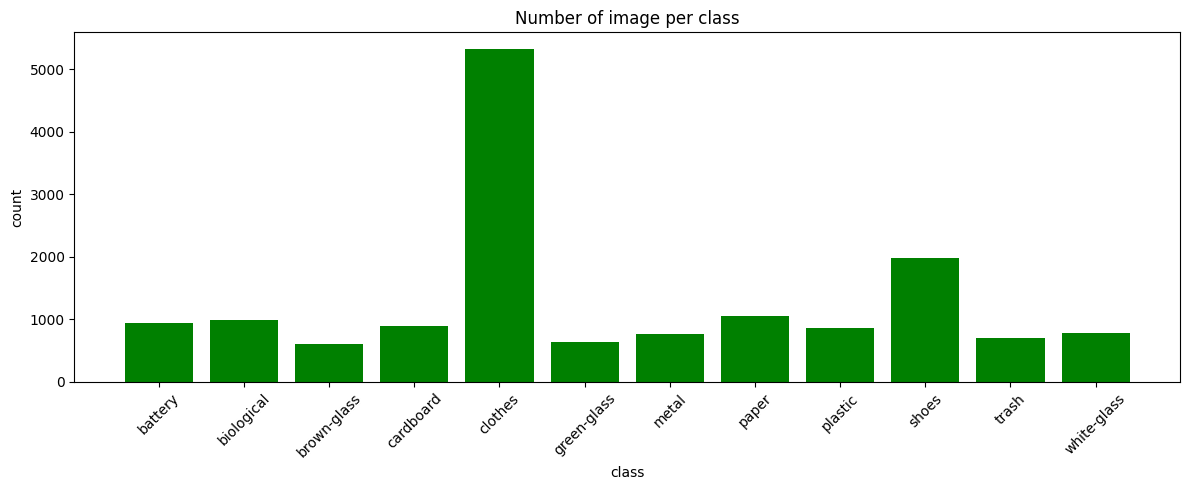

In [67]:
plt.figure(figsize=(12, 5))
plt.bar(class_counts.keys(),class_counts.values(),color='green')
plt.title("Number of image per class")
plt.xlabel("class")
plt.ylabel("count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

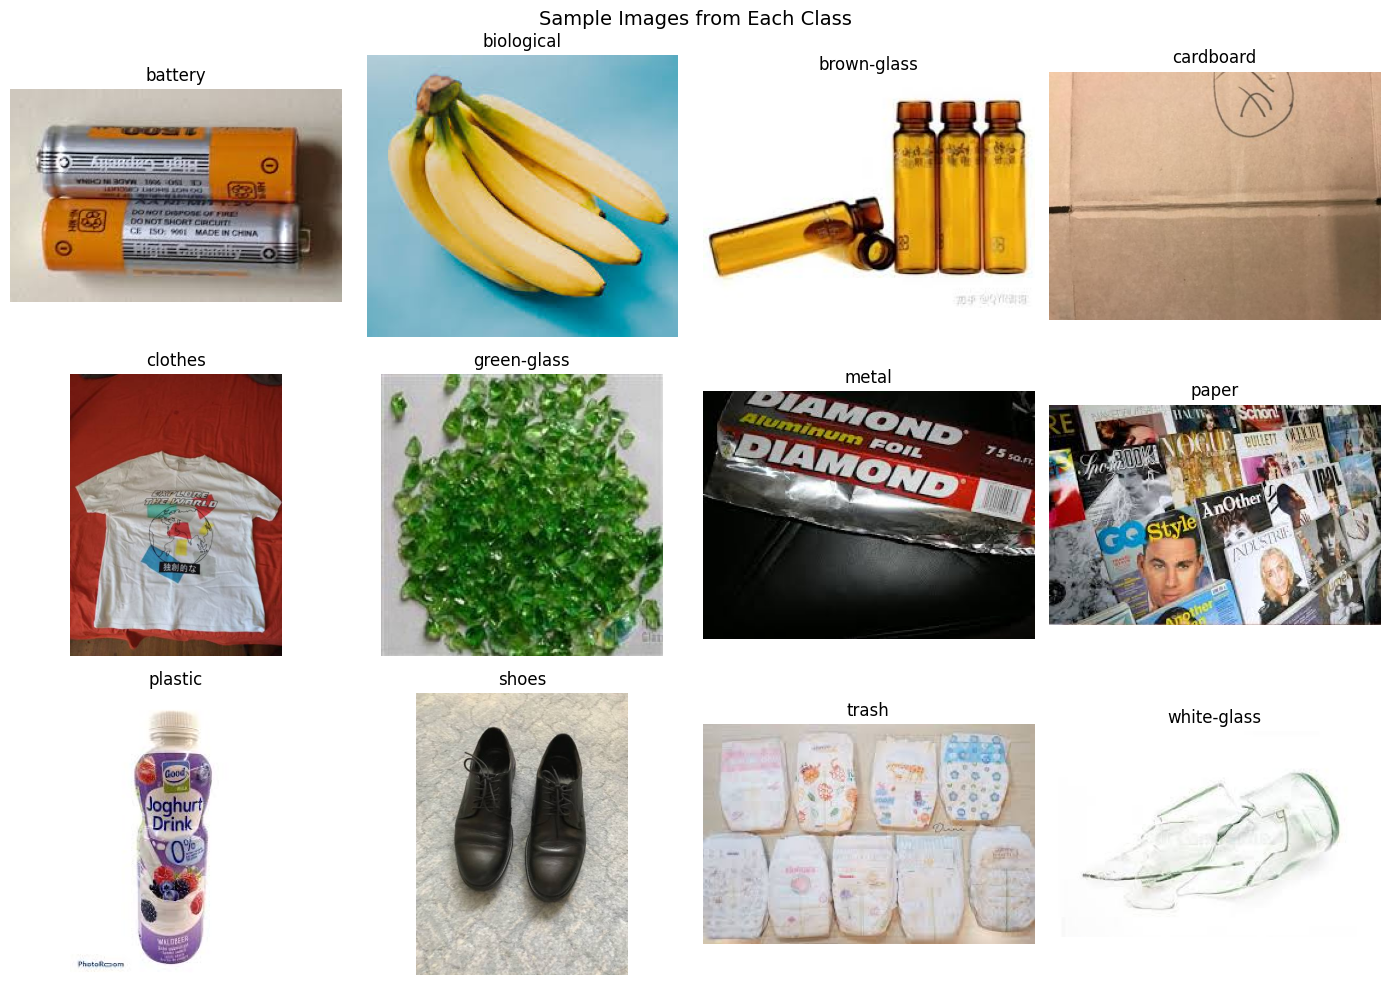

In [68]:
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
for ax, class_name in zip(axes.flatten(), os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    img_file = os.listdir(class_path)[0]
    img = Image.open(os.path.join(class_path, img_file))
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')
plt.suptitle("Sample Images from Each Class", fontsize=14)
plt.tight_layout()
plt.show()

In [69]:
Training_transformer =transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3,contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.488,0.489,0.490],
        std=[0.229,0.224,0.225])
])

val_transformer = transforms.Compose([
      transforms.Resize((224,224)),
       transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.488,0.489,0.490],
        std=[0.229,0.224,0.225])
])

print("✅ Transforms defined!")

✅ Transforms defined!


In [70]:
full_dataset =datasets.ImageFolder(root=data_dir,transform=Training_transformer)


class_name=full_dataset.classes

print("Classes",class_name)
print("Totalimage",len(full_dataset))


total =len(full_dataset)
train_size = int(0.8 * total)
val_size = int(0.1 * total)
test_size =total -train_size - val_size

train_set,val_set,test_set =random_split(full_dataset,[train_size,val_size,test_size])

print(f"Train: {train_size} | Val: {val_size} | Test: {test_size}")

Classes ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Totalimage 15515
Train: 12412 | Val: 1551 | Test: 1552


In [71]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False)

print("✅ DataLoaders ready!")

✅ DataLoaders ready!


In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Freeze all base layers
for param in model.parameters():
    param.requires_grad = False    


num_classes = 12
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.3),
    nn.Linear(256, num_classes)
)
model = model.to(device)
print("✅ Model ready!")
print(f"Output classes: {num_classes}")


Using device: cpu
✅ Model ready!
Output classes: 12


In [73]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

print("✅ Loss and Optimizer defined!")

✅ Loss and Optimizer defined!


In [74]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_acc = 0.0

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100. * correct / total

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)

        val_acc = 100. * val_correct / val_total

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print(f"  ✅ Best model saved! Val Acc: {val_acc:.2f}%")

    print(f"\n🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
    return model

In [75]:
# print("🚀 Starting Phase 1 Training (frozen base)...")
# model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

In [76]:
# print("🔓 Phase 2: Fine-tuning top layers...")

# # Unfreeze top 3 feature blocks
# for param in model.features[-3:].parameters():
#     param.requires_grad = True

# # Very small learning rate
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# # ✅ Pass criterion and optimizer explicitly
# train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

In [77]:
# from google.colab import files
# files.download("best_model.pth")   # ✅ Correct filename

              precision    recall  f1-score   support

     battery       0.87      0.97      0.92        78
  biological       0.89      0.98      0.93        99
 brown-glass       0.91      0.97      0.94        60
   cardboard       0.99      0.91      0.94        85
     clothes       0.98      0.99      0.98       506
 green-glass       0.95      0.94      0.94        63
       metal       0.95      0.81      0.88        78
       paper       0.92      0.88      0.90       113
     plastic       0.84      0.87      0.85        93
       shoes       0.96      0.93      0.95       224
       trash       0.93      0.92      0.92        71
 white-glass       0.84      0.88      0.86        82

    accuracy                           0.94      1552
   macro avg       0.92      0.92      0.92      1552
weighted avg       0.94      0.94      0.94      1552



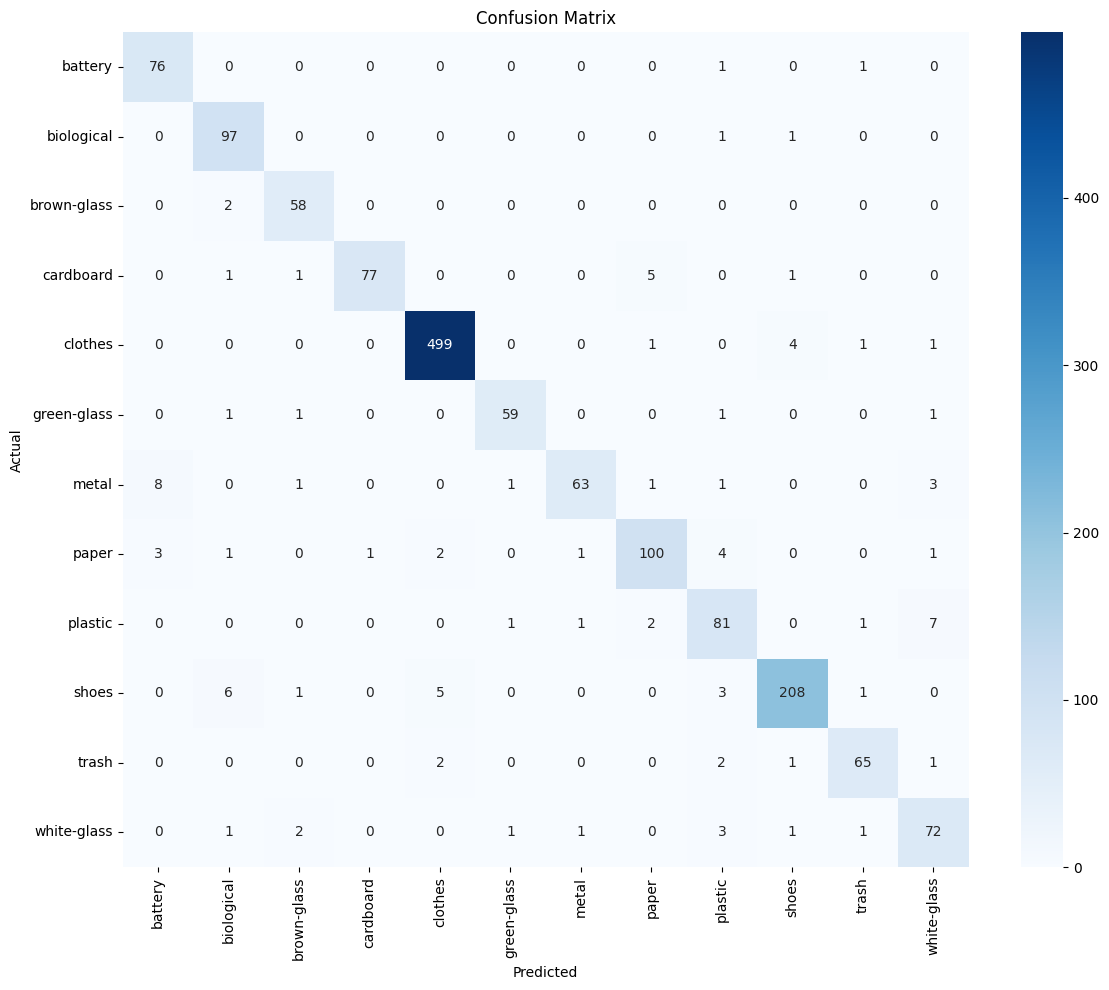

In [79]:
class_names = ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names,
            yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()